# Pre-SN variability: tutorial

Developed by Tobias Géron at the University of Toronto.

This code was developed to help better quantify detection thresholds with the Rubin pipelines. The current Rubin pipelines define detections with a simple SNR threshold. However, this becomes difficult when there is a bright background galaxy, or when the datapoint in question has a magnitude around the detection threshold (~23-24). How confident are we that this detection is real? This code was created with a specific science goal in mind: pre-SN variability. However, it can be used in any science context where you want to better understand the detection thresholds. We aim to answer the question: "Using the Rubin pipelines, in this specific epoch, using this specific template, how likely is it that a datapoint of X mag is detected?" 

This is answered using a series of source injection (see Parts I-II), image subtraction (see Part III), and forced photometry (see Part IV). This is repeated for multiple injection locations and multiple magnitude ranges. The output of the pipeline is a recovery curve (see Part VII), which you can use to compute the 80% or 50% detection fraction thresholds (i.e. the magnitude where X% of sources with magnitude Y would be detected with the Rubin pipelines at this specific epoch and this specific template; see Part VIII).

This is an in-depth tutorial on how to use this package, which will explain the different steps involved.

### Import packages, config, and some additional functions
Before we start, we must import everything we need. We use a lot of packages, both part of the LSST pipeline and others. We also define some additional functions to help generate simulated data to work on.

In [2]:
from pre_sn_variability import * # Import all functions

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
#from astropy.io import fits
#import scipy.stats as stats


# Various LSST pipelines
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service

In [3]:
# Additional config
service = get_tap_service("tap")

butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)

afwDisplay.setDefaultBackend('matplotlib')

In [4]:
# Logging config

import logging

task_names = ['lsst.alardLuptonSubtract', 'lsst.visitInjectTask',
             'lsst.measurement']

for tn in task_names:
    logger = logging.getLogger(tn)
    logger.setLevel(logging.WARNING)  

'''
the different levels are DEBUG, INFO, WARNING, ERROR, CRITICAL
'''

'\nthe different levels are DEBUG, INFO, WARNING, ERROR, CRITICAL\n'

In [5]:
# Additional functions

def add_2009ip(target_mjd, target_dist = 100, target_peak = 61100, rescale = 1):
    '''
    Loads R band lightcurve of 2009ip. Rescales it to any distance. Output what flux (in nJy) would be at any MJD. 

    target_dist in Mpc
    target_peak in MJD

    Output in flux
    
    '''
    peak_2009ip = 56203 #MJD
    dist_2009ip = 24 #Mpc, luminosity distance
    
    df_2009ip = pd.read_csv('data/2009ip/2009ip.csv')
    df_2009ip['MJD'] -= peak_2009ip

    inds_keep = np.where((df_2009ip['MJD'] > -np.inf) & (df_2009ip['MJD'] < np.inf))[0] # Only keep +-100 days around SN.
    df_2009ip = df_2009ip.iloc[inds_keep].reset_index(drop=True)

    
    df_2009ip['MJD_adj'] = df_2009ip['MJD'] * rescale
    df_2009ip['MJD_adj'] = df_2009ip['MJD_adj'] + target_peak 
    df_2009ip['flux'] = mag_to_njy(df_2009ip['mag_R']) #nJy
    df_2009ip['flux_adj'] = df_2009ip['flux']*dist_2009ip**2 / target_dist**2 # Just solve F = L/(4pi * r **2) for the two different fluxes, and L1 = L2

    fluxes = np.interp(target_mjd, df_2009ip['MJD_adj'], df_2009ip['flux_adj'], left = 0, right = 0)
    return fluxes



def inject_data(calexp, template, coord_sn, coord_gal, mjd, rotation_angle, sn_peak = 61300, sn_dist = 130, 
                gal_path = 'data/ngc6308/ngc6308_cutout.fits', gal_mag = 13.844, band = 'g'):
    '''
    Takes a calexp and template image. Injects a galaxy in both, and a lightcurve of a SN in the calexp. Returns injected images. 
    '''

    ra_sn, dec_sn = coord_sn
    ra_gal, dec_gal = coord_gal 
    
    # Check if SN is in exposure
    if not in_exposure((ra_sn,dec_sn), calexp):
        print(f'Skipping {i} due to SN loc not in image...')
        return np.nan, np.nan
    
    # Inject the galaxy in calexp and template
    try:
          
        injection_catalog = create_injection_catalog([ra_gal],[dec_gal],['Stamp'],[gal_mag], 
                                                     stamp_loc = [gal_path], rotation = [rotation_angle])        
        calexp_inj, _ = inject_source(calexp, injection_catalog, band = band) 
        template_inj, _ = inject_source(template, injection_catalog, band = band)  
    except:
        print(f'Skipping {i} due to not being able to inject galaxy stamp...')
        return np.nan, np.nan

    

    # Inject 2009ip in calexp
    peak_flux = add_2009ip(mjd, target_dist = sn_dist, target_peak = sn_peak, rescale = 1)
    peak_mag = njy_to_mag(peak_flux) if peak_flux != 0 else np.inf
    if peak_mag < 40: # If it is fainter, dont't bother. Rubin pipelines sometimes seem to crash if you want to inject really faint stuff anyway
        injection_catalog = create_injection_catalog([ra_sn],[dec_sn],['Star'],[peak_mag])
        calexp_inj, _ = inject_source(calexp_inj, injection_catalog, band = band)

    return calexp_inj, template_inj

### Part 0: Create data

Note that this step is quite long, and can be skipped. We create artificial data (background galaxy + SN) that the pipelines can be used for. Once real data starts flowing in, this Part will be replaced with a real example. The end goal of this step is to create a science, template, difference image, as well as get a list of all the other sources in the image. If you just want to understand how the pipeline itself works, feel free to skip this step.

We select some ra/dec combination that is in DP0. We get the DatasetRef for every epoch this part of the sky was "observed" in DP0. We then store the information about each visit in `df_visit` (detector ids, visit ids, sky rotations, MJDs, ...). We then place a postage stamp of a known galaxy (NGC 6308) in every visit, as well as the light curve of SN 2009ip (a target that showed pre-SN activity). We place both at ~100 Mpc. We then use the Rubin pipelines to do image subtraction and forced photometry, so that we have a light curve of what SN 2009ip would have looked like at 100 Mpc, processed through the Rubin pipelines. We save the data in `df_exposure`. 

Note that we're not actually saving all the generated science, template and difference images themselves, due to memory constraints, but we have the information in df_visit to easily grab them again.

In [6]:
ra_gal, dec_gal = 56.622, -36.488
ra_sn, dec_sn = ra_gal + 3/60/60, dec_gal + 3/60/60 #offset by a few arcsec
band = 'r'

datasetRefs = butler.query_datasets("calexp", band=band, 
                                    where="visit_detector_region.region OVERLAPS POINT(ra, dec) "
                                    "AND visit_detector_region.region OVERLAPS POINT(ra_sn, dec_sn)",
                                    bind={"ra": ra_gal, "dec": dec_gal, "ra_sn": ra_sn, "dec_sn": dec_sn})

print(f"\nFound {len(datasetRefs)} calexps")


Found 131 calexps


In [7]:
# Get info from each visit. Especially the MJDs, as well as the sky rotation. 
df_visit = pd.DataFrame()

for datasetRef in tqdm(datasetRefs):
    visit_id = datasetRef.dataId['visit']
    
    query = "SELECT visit, skyRotation, expMidptMJD, band "\
            "FROM dp02_dc2_catalogs.Visit "\
            f"WHERE visit = {visit_id}"
    
    df_temp = service.search(query).to_table().to_pandas()
    df_visit = pd.concat([df_visit,df_temp])

# Add our detector ids
detector_ids = [datasetRef.dataId['detector'] for datasetRef in datasetRefs]
df_visit['detector'] = detector_ids

# Sort by mjd
df_visit = df_visit.sort_values(by='expMidptMJD').reset_index(drop=True)
mjd_min, mjd_max = np.min(df_visit['expMidptMJD']), np.max(df_visit['expMidptMJD'])

  0%|          | 0/131 [00:00<?, ?it/s]

In [8]:
# Remove duplicate days to make it clearer
df_visit['mjd_int'] = df_visit['expMidptMJD'].astype(int)
df_visit = df_visit[df_visit.duplicated(subset = 'mjd_int', keep = 'first') == False].reset_index(drop=True)
df_visit = df_visit.drop(columns=['mjd_int'])

In [9]:
# Randomly sample some datapoints. Will speed the rest up.
n_datapoints = 5
inds = np.random.choice(list(range(len(df_visit))), n_datapoints, replace=False)
df_visit = df_visit.iloc[inds]
df_visit = df_visit.sort_values(by='expMidptMJD').reset_index(drop=True)

In [10]:
df_visit.head()

,visit,skyRotation,expMidptMJD,band,detector
0,252422,182.271886,59929.147486,r,147
1,401615,3.920099,60147.394491,r,114
2,448317,330.374050,60224.168192,r,54
3,943323,339.758763,60961.245281,r,147
4,1195297,351.253479,61331.158758,r,40


In [11]:
plot = False

rows = [] #Collect the data in here

for i in tqdm(range(len(df_visit))):
    row = {} #Save all data here

    # Get the data
    visit = df_visit['visit'][i]
    detector = df_visit['detector'][i]
    dataId = {'visit': visit, 'detector': detector}
    
    calexp = butler.get('calexp', dataId=dataId)
    template = butler.get('goodSeeingDiff_templateExp', dataId=dataId)
    
    sources_calexp = butler.get('src', dataId=dataId)
    mjd = df_visit['expMidptMJD'][i]

    rotation_angle = df_visit['skyRotation'][i] 

    calexp_inj, template_inj = inject_data(calexp, template, (ra_sn, dec_sn), (ra_gal, dec_gal), mjd, rotation_angle, band = band)    
    if type(calexp_inj) != afwImage._exposure.ExposureF: #Sometimes the injection of the background galaxy/SNe is not successfull.
        continue
    
    # Create cutouts to speed things up.
    cutout_size = 1501 #in pixel units here
    calexp_inj = cutout_exposure(calexp_inj, ra_gal, dec_gal, size = cutout_size, size_units = 'pixel')
    template_inj = cutout_exposure(template_inj, ra_gal, dec_gal, size = cutout_size+20, size_units = 'pixel') #templates have a buffer region around edges. Need to account for that, hence the +20
    sources_calexp = filter_sources(sources_calexp, calexp_inj) #Only keep the sources that are actually also in the injected calexps cutout
    

    #  Subtract calexp and template to obtain diff
    diff_inj = subtract_images(template_inj, calexp_inj, sources = sources_calexp)


    
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(15,5))

        plot_image_v2(calexp_inj, ax = ax[0], zoom_target = (ra_gal,dec_gal), zoom_size = 40, scale = 'asinh', vmin = 60,title = 'Science', plot_ticks = False, plot_colorbar = False, fontsize = 30, coords = (ra_sn, dec_sn))
        plot_image_v2(template_inj, ax = ax[1], zoom_target = (ra_gal,dec_gal), zoom_size = 40, scale = 'asinh', title = 'Template', plot_ticks = False, plot_colorbar = False, fontsize = 30, coords = (ra_sn, dec_sn))
        plot_image_v2(diff_inj.difference, ax = ax[2], zoom_target = (ra_gal,dec_gal), zoom_size = 40, scale = 'linear',title = 'Difference', plot_ticks = False, plot_colorbar = False, fontsize = 30, coords = (ra_sn, dec_sn))

        plt.suptitle(f'{mjd}')
        plt.tight_layout()
        plt.show()

    
    # Get forced photometry on difference image
    fp = forced_photometry(diff_inj.difference, [[ra_sn, dec_sn]])

    #Save data in row
    row['mjd'] = mjd
    row['visit'] = visit
    row['detector'] = detector
    row['sky_rotation'] = rotation_angle

    # Save forced photometry in instflux
    instflux_diff = fp['base_PsfFlux_instFlux'][0]
    instflux_err_diff = fp['base_PsfFlux_instFluxErr'][0]
    row['diff_psfInstFlux'] = instflux_diff
    row['diff_psfInstFluxErr'] = instflux_err_diff

    # Save forced photometry in flux (njy)
    njy_diff = instflux_to_njy(instflux_diff, diff_inj.difference)
    njy_err_diff = instflux_to_njy(instflux_err_diff, diff_inj.difference)
    row['diff_psfFlux'] = njy_diff
    row['diff_psfFluxErr'] = njy_err_diff

    # Save forced photometry in mags
    row['diff_psfMag'] = instflux_to_mag(instflux_diff, diff_inj.difference)
    row['diff_psfMagErr'] = njyerr_to_magerr(njy_err_diff, njy_diff)

    rows.append(row)


df_exposure = pd.DataFrame(rows)
df_exposure['detected'] = [True if df_exposure['diff_psfFlux'][i] - 5* df_exposure['diff_psfFluxErr'][i] > 0 else False for i in range(len(df_exposure))]
df_exposure['5sigma_mag'] = njy_to_mag(5* df_exposure['diff_psfFluxErr'])

  0%|          | 0/5 [00:00<?, ?it/s]

Skipping 3 due to SN loc not in image...


In [12]:
df_exposure.head()

,mjd,visit,detector,sky_rotation,diff_psfInstFlux,diff_psfInstFluxErr,diff_psfFlux,diff_psfFluxErr,diff_psfMag,diff_psfMagErr,detected,5sigma_mag
0,59929.147486,252422,147,182.271886,348.675941,408.802826,170.213575,199.565792,25.822515,1.272964,False,23.902360
1,60147.394491,401615,114,3.920099,3421.417200,458.786572,1673.867609,224.453183,23.340697,0.145589,True,23.774761
2,60224.168192,448317,54,330.374050,2304.823185,456.072504,1129.645858,223.531427,23.767644,0.214843,True,23.779229
3,61331.158758,1195297,40,351.253479,368196.483418,1037.450386,181086.147001,510.238151,18.255287,0.003059,True,22.883143


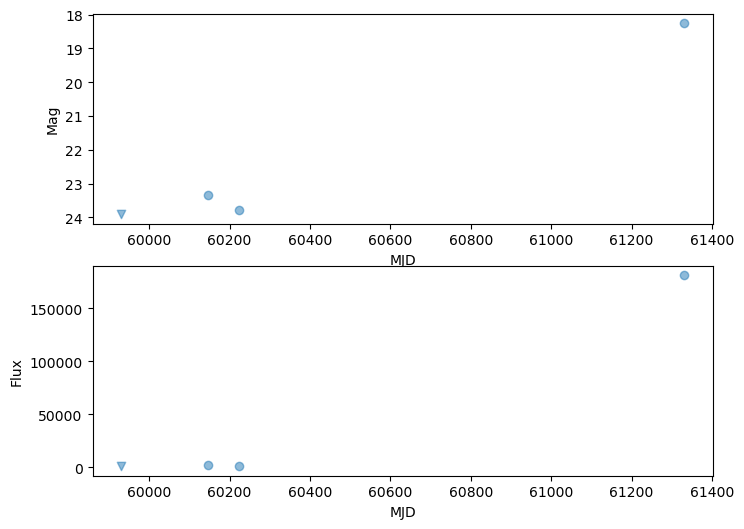

In [13]:
c = 'C0'

plt.figure(figsize = (8,6))
plt.subplot(2,1,1)
for i in range(len(df_exposure)):
        
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['mjd'][i], df_exposure['diff_psfMag'][i], c = c, alpha = 0.5)
    else:
        plt.scatter(df_exposure['mjd'][i], df_exposure['5sigma_mag'][i], marker = 'v', c = c, alpha = 0.5)
        

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Mag')


plt.subplot(2,1,2)
for i in range(len(df_exposure)):
        
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['mjd'][i], df_exposure['diff_psfFlux'][i], c = c, alpha = 0.5)
    else:
        plt.scatter(df_exposure['mjd'][i], mag_to_njy(df_exposure['5sigma_mag'][i]), marker = 'v', c = c, alpha = 0.5)
        
plt.xlabel('MJD')
plt.ylabel('Flux')

plt.show()

Select one specific epoch to run the code on. 

In [14]:
i = 2

mjd = df_exposure['mjd'][i]
visit = df_exposure['visit'][i]
detector = df_exposure['detector'][i]
rotation_angle = df_exposure['sky_rotation'][i]
dataId = {'visit': visit, 'detector': detector}

# Get calexp, template and sources from butler
calexp = butler.get('calexp', dataId=dataId)
template = butler.get('goodSeeingDiff_templateExp', dataId=dataId)
sources_calexp = butler.get('src', dataId=dataId)

# Inject the galaxy and SN in the images
calexp, template = inject_data(calexp, template, (ra_sn, dec_sn), (ra_gal, dec_gal), mjd, rotation_angle, band = band)    

# Get the difference image
diff = subtract_images(template, calexp, sources = sources_calexp).difference

# Get the SN mag from df_exposure
sn_mag = df_exposure['diff_psfMag'][i] if df_exposure['detected'][i] else df_exposure['5sigma_mag'][i]

Visualse the target using `plot_image()`. Note that we do not show the whole images, just the section around the region of interested (finetuned with the `zoom_target` and `zoom_size` arguments).

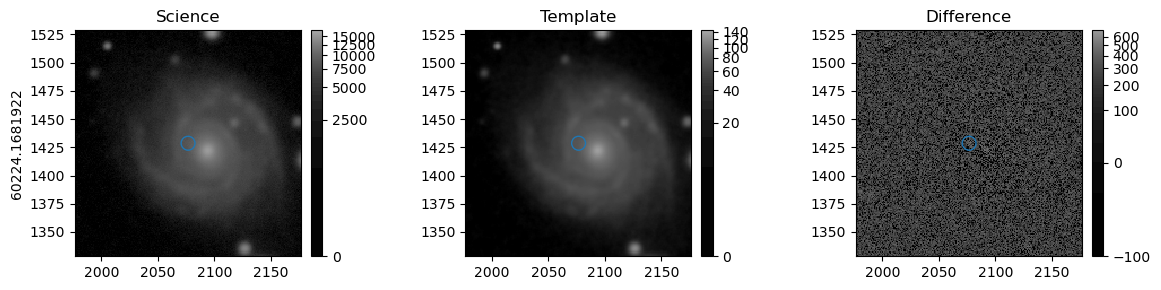

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))


plot_image(calexp, ax = ax[0], title = f'Science', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh')
plt.ylabel(mjd)
plot_image(template, ax = ax[1], title = f'Template', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh')
plot_image(diff, ax = ax[2], title = f'Difference', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh')

plt.tight_layout()
plt.show()

Create cutouts of the images using `cutout_exposure()`. They will speed up some of the later code. Now we're all set to go.

In [16]:
cutout_size = 1501 #in pixel units here
calexp_cutout = cutout_exposure(calexp, ra_sn, dec_sn, size = cutout_size, size_units = 'pixel')
template_cutout = cutout_exposure(template, ra_sn, dec_sn, size = cutout_size+20, size_units = 'pixel') #templates have a buffer region around edges. Need to account for that, hence the +20

### Part I: Finding injection locations
The first step of the pipeline involves selecting locations in the image to inject the fake SN in. We can easily do that with the fuction `create_injection_locations()`. Note that this function does not do the actual injection, but finds the appropriate locations. 

We will first smooth the exposure, and then find injection sites that have similar flux values to the SN site in the template image. Because of this, we also require the template exposure as an argument. There are multiple arguments to finetune this process. First, you must specify the number of desired injection sites with `n_injection`. You can specify the smoothening filter and the size of the filter in pixels by changing `smooth_function` and `smooth_filter_size`. The defaults for these arguments are 'median' and 10, respectively. You can use the `p_threshold` argument to finetune the precision with which the injection locations are found. The default `p_threshold = 5` means that any injection site will have a flux within 5% of the flux of the location of the SN on the template image. You can also insert the maximum distance (in arcsec) from the SN location where we can look for injection locations using `max_dist` (default is 20 arcsec). You want to enter a distance that covers the entire galaxy, but not other nearby galaxies (or foreground stars). 

Note that we're zooming in on the SN in the plots below (by using `plot_zoom = True`), to better visualise the results.

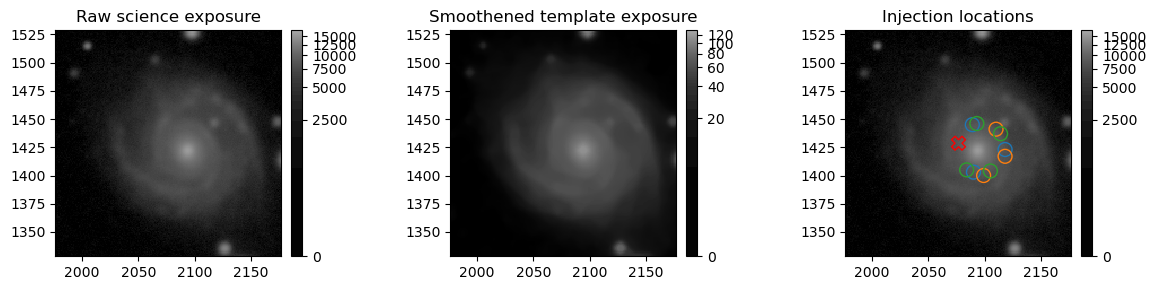

In [17]:
injection_locations = create_injection_locations(calexp_cutout, n_injections = 10, template_exposure = template_cutout, 
                                                 sn_position = (ra_sn,dec_sn), plot = True, plot_zoom = True, max_dist = 20)

Note the different coloured rings. To save time, the pipeline will inject multiple fake SN at the same time and analyse them together. All injection locations will with the same colour with be injected together (i.e. they belong to the same 'injection iteration'). These locations are combined in such a way so that they do not overlap. 

This is done as follows. For every possible injection location, we calculate a minimum distance it needs to be separated from other possible injection locations. We want to be cautious in this step as we want to avoid any possibility of overlap and leaking into nearby injection locations. Therefore, this is done in a two-step process. We start by looking at the PSF at each possible injection location to find the distance at which 99.99% of the flux of the normalized PSF is contained. This percentage can be changed using the parameter `psf_flux_threshold` (default: 0.0001, or 0.01%). Then, to make sure we are extremely cautious, we calculate the $\sigma$ of the PSF and add a multiple of it to that radius. This multiple can be changed with the parameter `psf_sigma` (the default is 3). 

Below, we change these thresholds to be less conservative, and you'll notice than more injection locations have the same colour. This implies they'll be injected and analysed together. This will speed up the pipeline, with the risk of leaking.



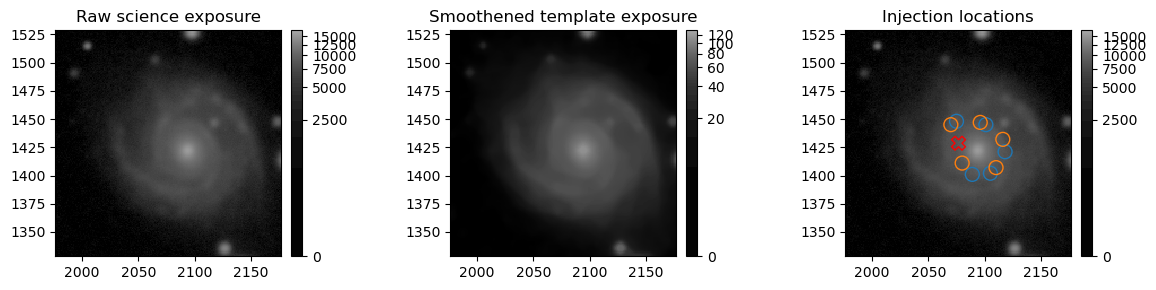

In [18]:
injection_locations = create_injection_locations(calexp_cutout, n_injections = 10, template_exposure = template_cutout, 
                                                 sn_position = (ra_sn,dec_sn), plot = True, plot_zoom = True,
                                                 psf_flux_threshold = 0.001, psf_sigma = 1, max_dist = 20)

We strongly suggest to use the default options here. It optimises the number of injection sites you can use simultaneously, which speeds up the code, while minimising the possibility of overlap and interference of the SN and other injection sites. Although it can be a bit overly cautious. We have noticed that when using less strict constraints and injecting very bright SN, some light can leak into nearby injection locations. However, if you wish, you can always relax the thresholds (`psf_flux_threshold` and `psf_sigma`) or even disable them (setting either `psf_flux_threshold = 1` or `psf_sigma = 0`).

### Part II: Injecting sources
The second part of the pipeline involves actually injecting the sources. This package contains a fast and easy way to do that. Here, we will inject all sources of the first injection iteration. 

We first need to create an injection catalog. This can easily be done with `create_injection_catalog()`. This is then used in `inject_source()` to inject it in an exposure.

Note that we have to use full images in the injection routine because of how the Rubin source injection pipelines work. However, we can inject in the full image, and then create a cutout of the injected image. We can still use the cutouts to speed up finding the injection locations in the previous step, though. 

In [19]:
# Create injection locations and select the first injection iteration (see step above)
injection_locations = create_injection_locations(calexp_cutout, n_injections = 10, template_exposure = template_cutout, 
                                                 sn_position = (ra_sn,dec_sn), method = 'smooth')
injection_locations = injection_locations[0]
ra_inj = np.array(injection_locations)[:,0]
dec_inj = np.array(injection_locations)[:,1]

# Create the injection catalog 
injection_catalog = create_injection_catalog(ra_inj,dec_inj,['Star']*len(injection_locations),[sn_mag]*len(injection_locations))

# Inject the source
inj_calexp, _ = inject_source(calexp, injection_catalog, band = 'g')

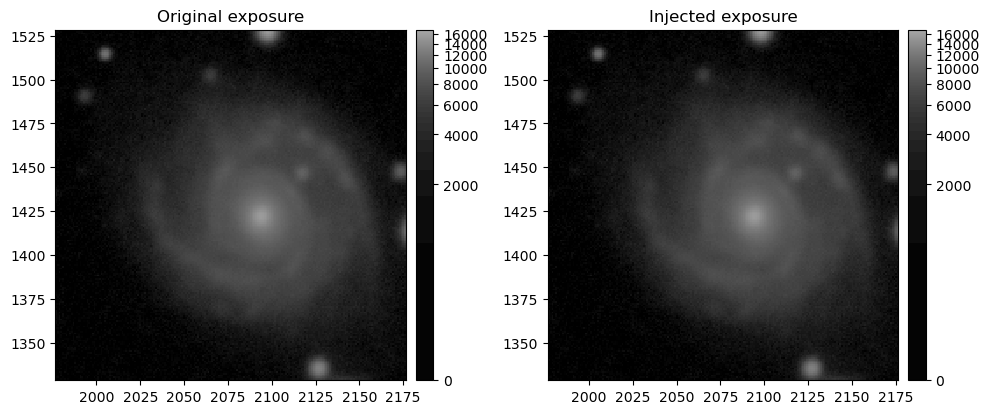

In [20]:
# Visualise injection

fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_image(calexp, ax = ax[0], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Original exposure')
plot_image(inj_calexp, ax = ax[1], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Injected exposure')
plt.tight_layout()
plt.show()

In [21]:
# create a cutout of the injected science image
inj_calexp_cutout = cutout_exposure(inj_calexp, ra_sn, dec_sn, size = cutout_size)

Note that, if the magnitude of the injected sources is faint, you might not see anything in the images above.

### Part III: Image subtraction
Now that we have our injected image, we can perform image subtraction with a template. We use the LSST AlardLuptonSubtractTask, which is wrapped in the `subtract_images()` function. In addition to the injected exposure and the template, this task also needs other sources in the image. The subtraction itself is straight-forward. Just note that we need to filter the sources that are also in the cutout, which is done with `filter_sources()`.

We use the AlardLuptonSubtractTask to do the subtraction. Note that you can also pass a `config` parameter to `subtract_images()`. This should be a `lsst.ip.diffim.subtractImages.AlardLuptonSubtractConfig`. This allows you to finetune the details of the subtraction. If you do not specify this parameter, we will use the default config. Strongly recommended to keep this to default, unless you are confident in what you want to change. 

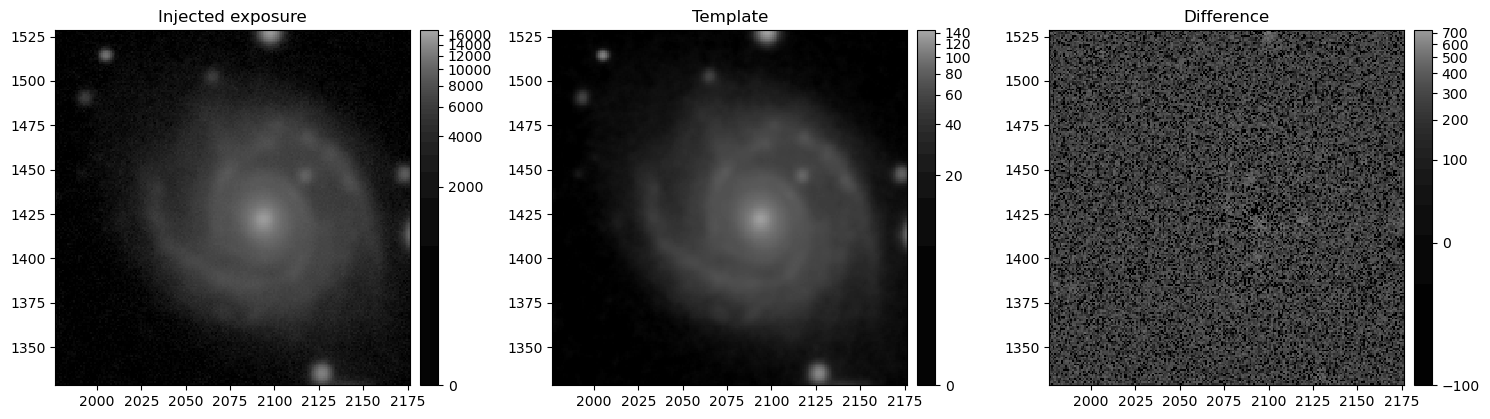

In [22]:
# Do the subtraction 
sources_calexp_cutout = filter_sources(sources_calexp, inj_calexp_cutout) #Only keep the sources that are actually also in the injected calexps cutout
diff_cutout = subtract_images(template_cutout, inj_calexp_cutout, sources_calexp_cutout)


# Visualise subtraction
fig, ax = plt.subplots(1,3, figsize=(15, 9))
plot_image(inj_calexp_cutout, ax = ax[0], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Injected exposure')
plot_image(template_cutout, ax = ax[1], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Template')
plot_image(diff_cutout.difference, ax = ax[2], zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh', title = 'Difference')
plt.tight_layout() 
plt.show()

### Part IV: Forced photometry

Now we'll perform forced photometry on the subtracted image at these injection locations. This can be done with the `forced_photometry()` function. It needs the difference image obtained through the steps above, and the previously defined injection locations.

In [23]:
df_forced = forced_photometry(diff_cutout.difference, injection_locations)
df_forced.head()

,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_SNR,base_PsfFlux_area
0,2783.743512,454.457296,6.125424,52.199486
1,3104.211016,442.939505,7.008205,52.199486
2,2851.065236,454.634844,6.271110,52.199486


### Part V: Combining the above
So far we have talked about injecting the sources, image subtraction and forced photometry (steps II-IV). You can do these steps separately as shown above. However, to make things much easier, the fuction `inject_subtract_photometry()` does all of these steps automatically in the correct order. This function needs the science image, injection locations, sn_mag, the other sources in the image, and the template.

However, in order to speed things up significantly, we can pass an additional `cutout_size` argument. This is the distance in arcsec around the SN that we care about. The source injection will still happen on the full image, as required by the Rubin pipelines, but the image subtraction will only happen on the cutouts. This speeds things up *significantly* and we highly recommend doing this. The only caveat is that there should still be enough sources in the background to do the subtraction with. About 100 sources seems good, which in this case corresponds to a cutout_size of roughly 300 arcsec. More sources are better, at the cost of time. 

Note that the plot only shows one injection iteration, not all of them. 

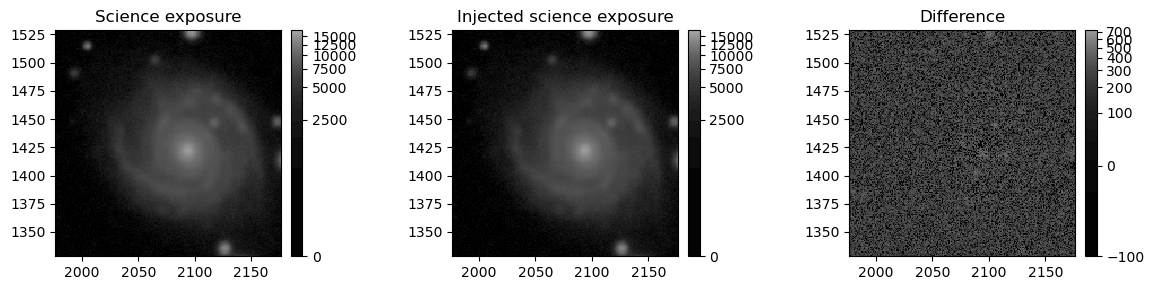

,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_SNR,base_PsfFlux_area,n_injection_iteration,injection_x,injection_y,injection_ra,injection_dec,injection_id
0,2871.441417,453.400737,6.333120,52.199505,0,2093.0,1400.0,56.622842,-36.488990,0_0
1,2518.921209,457.796637,5.502271,52.199505,0,2111.0,1411.0,56.621385,-36.488957,0_1
2,2792.712546,451.793700,6.181389,52.199505,0,2092.0,1446.0,56.621322,-36.486747,0_2
3,1984.063309,442.177972,4.487024,52.199505,0,2114.0,1437.0,56.620312,-36.487787,0_3
0,2942.040996,453.591196,6.486107,52.199497,1,2117.0,1427.0,56.620475,-36.488352,1_0


In [24]:
# Get the injection locations, using only the cutout
injection_locations = create_injection_locations(calexp_cutout, n_injections = 10, template_exposure = template_cutout, 
                                                 sn_position = (ra_sn,dec_sn))

# Do source injection - image subtraction - forced photometry
df_results = inject_subtract_photometry(calexp, injection_locations = injection_locations, injection_mag = sn_mag, sources = sources_calexp, 
                     template_exposure = template, plot = True, plot_zoom = True, sn_position = (ra_sn,dec_sn), cutout_size = 300)

df_results.head()

### Part VI: Background noise

Before we continue, we need to talk about image subtraction. The subtraction pipeline is not perfect, it is a hard problem, especially when there is a bright background galaxy. Sometimes some pixels are registered as a detection (SNR > 5 in the difference image), even when there is not anything there. To investigate whether this is the case for your particular image, you can use `measure_snr_on_img()`.

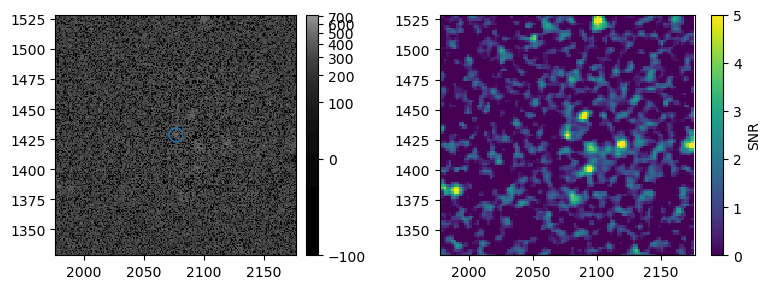

In [25]:
_ = measure_snr_on_img(diff_cutout.difference, (ra_sn,dec_sn), zoom_size = 40, stepsize = 2, plot = True)


There can be a lot of detections at various places in this image, even when there shouldn't be. This isn't always the case, but typically happens when the background galaxy is very bright. This will affect both the original SN measurement made by the Rubin pipelines, as well as the measurements we make ourselves. We can estimate the contribution of this issue to the original SN measurement. This is done by finding all pixels that have similar flux values to the SN site in the template image, seeing what flux they have in the science image, and subtracting that from the SN flux. This is done with the `estimate_sn_background()` function. Ideally you want the background flux to be centered around zero. But if it isn't, then you can subtract the median from the sn mag.

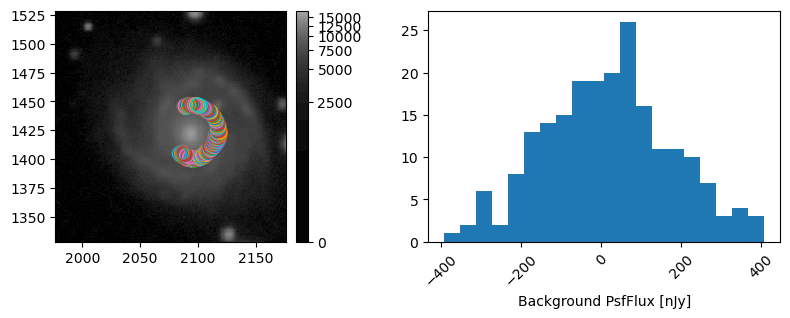

In [26]:
df_background = estimate_sn_background(calexp, template, sources = sources_calexp, sn_position = (ra_sn,dec_sn),
                             p_threshold = 5, plot = True)


# First convert SN magnitudes to nJy, then subtract median (or mean) of the background, then convert back to mag. 
sn_njy = mag_to_njy(sn_mag) - np.median(df_background['base_PsfFlux_nJy'])
sn_mag_new = njy_to_mag(sn_njy)

### Part VII: Creating a recovery curve
We are almost there! The goal of this package is to generate a final recovery curve. We can do that by calling `inject_subtract_photometry()` multiple times for different magnitudes (sn_mags), and checking what fraction of injected sources are detected at each value of sn_mag. This is done automatically with the `recovery_curve()` function. 

This function needs the sn_mag, the science exposure, the template exposure, the other sources in the image and the SN position as inputs. Additional settings can be adjusted through the `recovery_curve_config` class. 

There are a lot of settings that can be tweaked, but we'll go through some important ones here. The `recovery_curve()` fuction creates a range of sn magnitudes to check. It is important to sample the transition region where the detection fraction goes from 1 to 0. This is done in different steps defined by the `n_mag_steps`. E.g., if n_mag_steps == [4,10], it'll first sample 4 magnitudes. It'll then zoom further in and sample 10 magnitudes in the next iteration. The default is [4,4,4,8,20]. This means it'll first sample 4 magnitudes, then zoom in and sample another 4, then another 4, another 8, and finally 20. The precision on the detection fraction depends on `n_injections`. If n_injections = 10, then we will only be precise with steps of 0.1 (i.e. 1/n_injections). The default is 10. Additionally, `cutout_size` determines the size of the cutout. As discussed above, smaller cutouts significantly speed things up, but we still need enough sources in the image to properly do the subtraction. The default option is to not use a cutout, but we strongly suggest to change this to your needs. Here a cutout_size of 300 arcsec seems to do the job. Additionally, as covered above, the subtraction pipeline doesn't always work perfectly. Some injection locations will always register as detections. We can account for that using the `subtract_background` parameter (default is True). If enabled, we first measure the baseline background before injecting fake sources and then subtract that from the measured value before determining whether the injected source is detected. Finally, the `n_jobs` parameter is used to parallelise the code. It should not exceed the number of available CPU cores.

Running this might take a few minutes per epoch. The `n_mag_steps`, `n_injection`, `cutout_size` and `n_jobs` parameters are the most important arguments to finetune if the pipeline takes too long. The biggest time sink is the Rubin image subtraction. Unfortunately, the nature of the pipeline requires us to use that, so we cannot make any improvements there. 

The `recovery_curve()` function returns a Pandas DataFrame where every row represents a injected source with magnitude `sn_mag`. The DataFrame contains a bunch of information. But most importantly, it contains a column with what fraction of these injections are recovered (`detected`). You can expand the output of this function by doing `expand_output = True`, in which case a more detailed DataFrame is returned. Here, every row represents a single injection location over a single inject sn magnitude. You can obtain the former from from the latter output by doing: 

`df_summary = recovery_summary(df_recovery)`

Finally, it is good practise to pass the complete images you obtain from Rubin. We create cutouts within the function where appropriate. This also ensures that the wcs of each image behaves as expected.

Note that this may take a while to run. 

  0%|          | 0/5 [00:00<?, ?it/s]

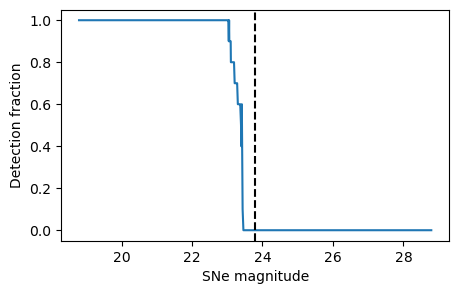

In [27]:
config = recovery_curve_config()
config.expand_output = True # To get the expanded output. Can recover the summary by using the recovery_summary() function.
config.plot = True
config.n_injection = 10 
config.n_mag_steps = [4,4,4,8,20]
config.cutout_size = 300 # Strongly encouraged to add cutout size. 
config.n_jobs = 4 # Assuming we have 4 cores available

df_recovery = recovery_curve(sn_mag = sn_mag_new, science_exposure = calexp, template_exposure = template, 
                sources = sources_calexp, sn_position = (ra_sn,dec_sn), config = config)

In [28]:
df_summary = recovery_summary(df_recovery)

In [29]:
df_summary.head()

,sn_mag,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_SNR,detected,background_nonzero_flag
0,18.791731,226633.969198,993.083649,229.259526,1.0,0.2
1,22.125065,10548.826214,716.055108,14.963082,1.0,0.2
2,22.458398,7763.986218,711.782375,11.077501,1.0,0.2
3,22.791731,5707.217326,708.588884,8.192489,1.0,0.2
4,22.925065,5019.125691,707.492652,7.211432,1.0,0.2


Here is a description of some of the remaining options in `recovery_curve_config()`. A complete list can be found in the readme.

**Description parameters** 

We try to be smart while sampling the recovery curve. We will have multiple rounds of sampling and slowly zoom in to the
region where the curve goes from 1 to 0. The following parameters define this process.  
`n_mag_steps`: list of ints. Defines how many mag steps in each iteration. Better to start low, and go up. It is important to sample the transition region where the detection fraction goes from 1 to 0. This is done in different steps defined by the `n_mag_steps`. E.g., if n_mag_steps == [4,10], it'll first sample 4 magnitudes. It'll then zoom further in and sample 10 magnitudes in the next iteration. The default is [4,4,4,8,20]. This means it'll first sample 4 magnitudes, then zoom in and sample another 4, then another 4, another 8, and finally 20.    
`sampling_buffer`: float. During the first iteration, we create a range around the sn_mag. The buffer defines how far out on each side.   
`mag_limits`: list of floats. If the transition region is not found in the first iteration, we simply set the limits of the search to this.  

Related to image smoothing:  
`injection_method`: can be either 'random' or 'smooth'. When random, we just return random pixels in the inmage. When smooth, we first smooth the template image, and then try to find pixels that are similar to the target SN. Very highly recommended to use smooth.  
`smooth_function`: the function used to smooth.  
`smooth_filter_size`: int. The size of the filter, in pixels.  

Related to finding injection locations:  
`n_injections`: int or list of ints. The amount of injections at each iteration. The precision on the detection fraction depends on this. E.g. if n_injections = 10, then we will only be precise with steps of 0.1 (i.e. 1/n_injections).  
`max_inj_per_round`: int. The maximum number of injections done per injection iteration. We try to speed the code up by selecting injection locations that can be injected, subtracted and measured together without influencing each other. If you do not want this behaviour, and prefer to only inject one fake source at the time, you can set this variable to 1.  
`p_threshold`: int. We try to find injection sites that are similar to the target SN. Every injection site will be p_threshold percent 
within the value of the pixel at the SN location in the template image.  
`psf_flux_threshold`: float. Used when creating the injection iterations. We do not want to plce injection sites too close together. We look at the PSF of each injection location and find the distance at which 1 - psf_flux_threshold of the flux of the normalized PSF is contained and make sure to exclude other sites within that range.  
`psf_sigma`: In addition to the above, we also calculate the std of the PSF and add a psf_sigma multiple of that to this radius.   

Remaining parameters:    
`subtraction_config`: We use the AlardLuptonSubtractTask to do the subtraction. Note that you can also pass a `config` parameter to `subtract_images()`. This should be a `lsst.ip.diffim.subtractImages.AlardLuptonSubtractConfig`. This allows you to finetune the details of the subtraction. If you do not specify this parameter, we will use the default config. Strongly recommended to keep this to default, unless you're confident in what you want to change.
`snr_threshold`: float. What SNR threshold defines a detection. Default Rubin value is 5.   
`subtract_background`: bool. Whether to automatically subtract the background.  
`cutout_size`: int. We recommend to input the full images, but we fill create a cutout ourselves for the majority of the tasks to speed things up. Units are arcsec. Default is NaN, but very highly recommended to use a value. It needs to be high enough to still include other sources for the subtraction. Around 300 seems usually appropriate.  
`sn_position_units`: string. Whether the sn_position is in pixel units or sky units.  
`plot`: Whether to automatically output plots.  
`expand_output`: bool. If True, we expand the output to contain much more detail. You can recover the summarised dataframe by doing: `df_recovery = recovery_summary(df_expanded_output)`.  
`n_jobs`: Used to specify how many parallel processes should be used to complete this. Should not exceed number of available CPU cores. Can disable this functionality by doing n_jobs = 0. Parallelisation happens over inject_subtract_photometry() with different sn_mags. 
 

### Part VIII: Finding detection threshold values

We now have the recovery curve, but we still have to calculate the actual magnitude detection threshold values. Looking at the recovery curve, we notice that there are two important transition points $x_1$ and $x_2$. At magnitudes brighter than $x_1$, the recovery curve equals 1, i.e. the injected signal is always detected. At magnitudes fainter than $x_2$, the recovery curve equals 0, i.e. the injected signal is never detected. The interesting stuff happens between $x_1$ and $x_2$. We can fit the recovery curve with a model where we assume flat lines y = 1 and y = 0 before and after the transition points and linearly in between. I.e.:

$$
y = 
\begin{cases} 
1, & \text{if } x < x_1, \\
0, & \text{if } x > x_2, \\
mx + b, & \text{if } x_1 \leq x \leq x_2,
\end{cases}
$$

where

$$ m = \frac{-1}{x_2-x_1},\;\;\;  b = \frac{x_2}{x_2 - x_1}.$$

This has the added benefit that we can solve for any detection threshold analytically, even if we did not sample it. This is done automatically using the `find_thresholds()` function. It needs the summarised output of `recovery_curve()` as input, as well as the detection fractions thresholds you want. It will output the corresponding magnitude thresholds.

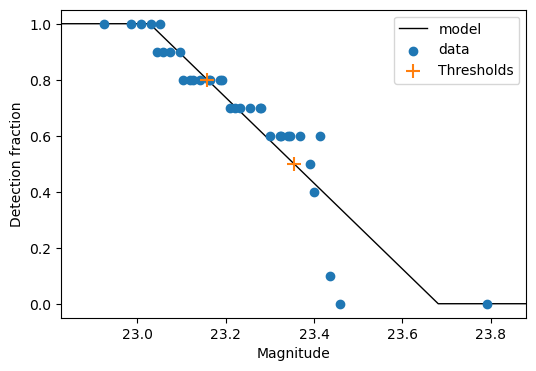

In [48]:
mag_limits = find_thresholds(df_summary,detection_fraction_thresholds = [0.5,0.8], plot = True)

In [49]:
mag_limits

{'lim_0.5': 23.35430303980346, 'lim_0.8': 23.158291713919137}

We can then compare these values to the sn magnitude to decide whether we trust it. 

In [50]:
sn_mag_new

23.791731367014002

### Part IV: Do this for all the timesteps
In Parts VII-VIII , we created a recovery curve for one timestep and calculated the appropriate magnitude thresholds. Let's loop over all timesteps now. This will take a while. 

Note that the structure of the cell below is as follows: define the config for the recovery. Then, loop over all epochs. Within the loop, we first obtain the data and images for this epoch. Then, we estimate estimate the background and correct, if needed. Then, we run the main part of the code and obtain the recovery curve and magnitude threshold values. Finally, we save the information.

Note that we loop over every epoch, and then load the correct calexp, template and difference image from the Bulter. This is done to save memory (as opposed to saving them all in memory together in Step 0 above).

In [52]:
# Define the config
config = recovery_curve_config()
config.cutout_size = 300 # Strongly encouraged to add cutout size. 
config.n_jobs = 4 # Assuming we have 4 CPU cores available


dfs = [] # We will save all recovery curves in here.



for i in tqdm(range(len(df_exposure))):

    ### ================================================== ###
    ### Part 0: retrieve the info and images of this epoch ###
    ### ================================================== ###
    
    # Get the information about this epoch from df_exposure
    mjd = df_exposure['mjd'][i]
    visit = df_exposure['visit'][i]
    detector = df_exposure['detector'][i]
    rotation_angle = df_exposure['sky_rotation'][i]
    sn_mag = df_exposure['diff_psfMag'][i]
    dataId = {'visit': visit, 'detector': detector}


    # Get the calexp, template and sources from the Bulter
    calexp = butler.get('calexp', dataId=dataId)
    template = butler.get('goodSeeingDiff_templateExp', dataId=dataId)
    sources_calexp = butler.get('src', dataId=dataId)

    # Inject the galaxy and SN in the science and template. This step will eventually be replaced with real data
    calexp, template = inject_data(calexp, template, (ra_sn, dec_sn), (ra_gal, dec_gal), mjd, rotation_angle, band = band)    

    # Get the difference image
    diff = subtract_images(template, calexp, sources = sources_calexp).difference
    
    
    
    
    ### ================================================= ###
    ### Part 1: Estimate background and adjust, if needed ###
    ### ================================================= ###


    # Correct for background
    df_background = estimate_sn_background(calexp, template, sources = sources_calexp, sn_position = (ra_sn,dec_sn),
                                     p_threshold = 5, plot = False)
        
    sn_njy = mag_to_njy(sn_mag) - np.median(df_background['base_PsfFlux_nJy']) # First convert SN magnitudes to nJy, then subtract median (or mean) of the background, then convert back to mag. 
    sn_mag_new = njy_to_mag(sn_njy)




    
    ### ================================================================== ###
    ### Part 2: Obtain recovery curve and thresholds, and save the results ###
    ### ================================================================== ###
    
    # Run the recovery curve code
    df_recovery = recovery_curve(sn_mag = sn_mag, science_exposure = calexp, template_exposure = template, 
                                    sources = sources_calexp, sn_position = (ra_sn,dec_sn), config = config)

    dfs.append(df_recovery)

    # Find the 0.5 and 0.8 thresholds
    fraction_thresholds = [0.5,0.8]
    mag_limits = find_thresholds(df_recovery, detection_fraction_thresholds = fraction_thresholds)


    # Save the data in df_exposure
    df_exposure.loc[i, 'sn_mag_new'] = sn_mag_new
    df_exposure.loc[i, 'sn_njy_new'] = sn_njy
    for ft in fraction_thresholds:
        df_exposure.loc[i, f'lim_{ft}'] = mag_limits[f'lim_{ft}']

    

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [53]:
df_exposure.head()

,mjd,visit,detector,sky_rotation,diff_psfInstFlux,diff_psfInstFluxErr,diff_psfFlux,diff_psfFluxErr,diff_psfMag,diff_psfMagErr,detected,5sigma_mag,sn_mag_new,sn_njy_new,lim_0.5,lim_0.8
0,59929.147486,252422,147,182.271886,348.675941,408.802826,170.213575,199.565792,25.822515,1.272964,False,23.902360,26.243108,115.546501,23.416775,23.266000
1,60147.394491,401615,114,3.920099,3421.417200,458.786572,1673.867609,224.453183,23.340697,0.145589,True,23.774761,23.414129,1564.402344,23.328636,23.194567
2,60224.168192,448317,54,330.374050,2304.823185,456.072504,1129.645858,223.531427,23.767644,0.214843,True,23.779229,23.782413,1114.383389,23.352222,23.250219
3,61331.158758,1195297,40,351.253479,368196.483418,1037.450386,181086.147001,510.238151,18.255287,0.003059,True,22.883143,18.254479,181220.888790,23.172416,23.071913


Make some plots to visualise the results

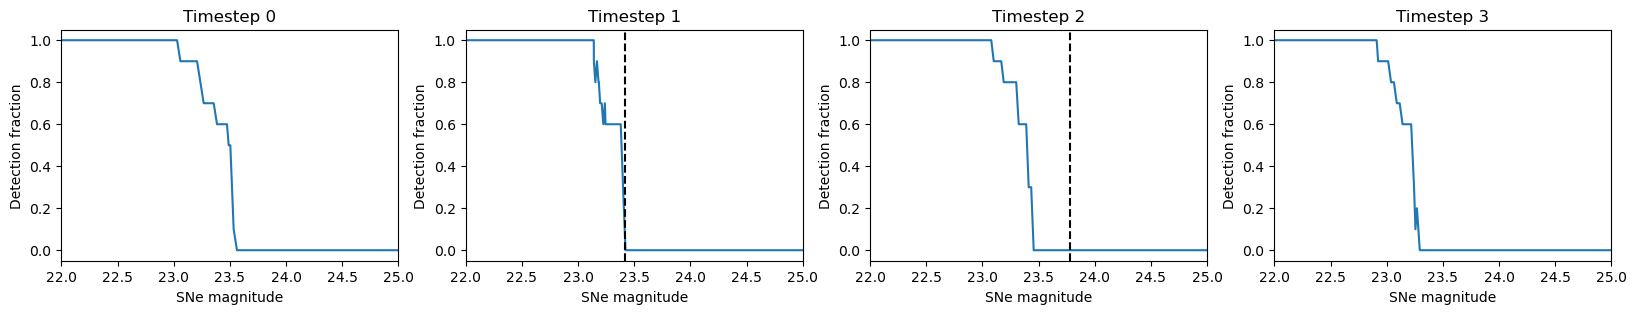

In [54]:
plt.figure(figsize = (len(dfs)*5,3))

for i,df_recovery in enumerate(dfs):

    plt.subplot(1, len(dfs), i+1)
    sn_mag = df_exposure['sn_mag_new'][i]
    plt.plot(df_recovery['sn_mag'], df_recovery['detected'])
    plt.ylabel('Detection fraction')
    plt.xlabel('SNe magnitude')
    plt.axvline(sn_mag, c = 'k', ls = '--')
    plt.xlim(22,25)
    plt.title(f'Timestep {i}')
    
plt.show()

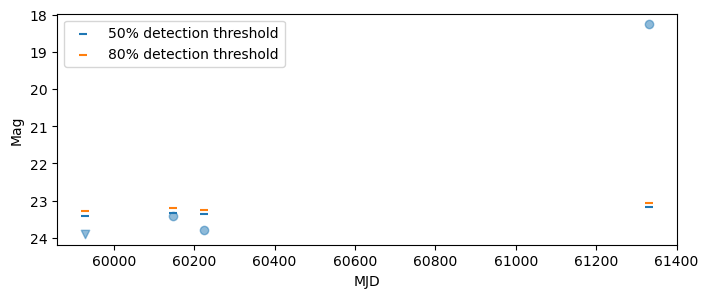

In [55]:
plt.figure(figsize = (8,3))

for ft in fraction_thresholds: # Plot the detection fractions
    plt.scatter(df_exposure['mjd'], df_exposure[f'lim_{ft}'], label = fr'{ft*100:.0f}% detection threshold', marker = '_')

for i in range(len(df_exposure)):
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['mjd'][i], df_exposure['sn_mag_new'][i], alpha = 0.5, c = 'C0')
    else:
        plt.scatter(df_exposure['mjd'][i], df_exposure['5sigma_mag'][i], marker = 'v', alpha = 0.5, c = 'C0')

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Mag')
plt.legend()
plt.show()